# Spectral Analysis of Neural Signals (Fixed Version)

This notebook performs FFT analysis on Hodgkin-Huxley model outputs with improved numerical stability.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
from src.model import HodgkinHuxleyModel

plt.style.use('seaborn-darkgrid')

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

/var/folders/j5/9drs1nyn0c37q_29h5sv9xdh0000gn/T/ipykernel_49218/1210539299.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
def safe_exp(x):
    """Numerically safe exponential function."""
    return np.exp(np.clip(x, -700, 700))

def analyze_spectrum(V, dt):
    """Compute FFT of voltage signal with improved handling."""
    n = len(V)
    
    # Remove DC component
    V_ac = V - np.mean(V)
    
    # Apply Hanning window
    window = np.hanning(n)
    V_windowed = V_ac * window
    
    # Compute FFT
    yf = fft(V_windowed)
    
    # Compute frequency points
    freqs = fftfreq(n, dt/1000)  # Convert dt to seconds for Hz
    
    # Compute power spectrum (normalize)
    power = 2.0/n * np.abs(yf[:n//2])
    freqs = freqs[:n//2]
    
    return freqs, power

def has_desired_spectrum(freqs, power, freq_range=(0, 100), power_threshold=0.1):
    """Check if spectrum has desired characteristics with improved robustness."""
    mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    if not np.any(mask):
        return False
    
    # Normalize power to maximum
    norm_power = power / np.max(power) if np.max(power) > 0 else power
    return np.max(norm_power[mask]) > power_threshold

In [3]:
def generate_test_signal(t_span, dt, signal_type='constant', **params):
    """Generate different types of test signals with careful parameter handling."""
    t = np.arange(t_span[0], t_span[1], dt)
    
    if signal_type == 'constant':
        amp = params.get('amplitude', 10)
        return lambda t: amp
    
    elif signal_type == 'sinusoidal':
        amp = params.get('amplitude', 10)
        freq = params.get('frequency', 0.1)
        return lambda t: amp * np.sin(2 * np.pi * freq * t/1000)
    
    elif signal_type == 'pulse':
        amp = params.get('amplitude', 15)
        period = params.get('period', 50)
        duty = params.get('duty', 0.5)
        return lambda t: amp if (t % period) < (period * duty) else 0
    
    elif signal_type == 'chirp':
        amp = params.get('amplitude', 10)
        f0 = params.get('f0', 0.1)
        f1 = params.get('f1', 1)
        return lambda t: amp * np.sin(2 * np.pi * (f0 + (f1-f0)*t/t_span[1]) * t/1000)
    
    elif signal_type == 'noise':
        amp = params.get('amplitude', 5)
        return lambda t: amp * (2*np.random.rand() - 1)
    
    return lambda t: 0

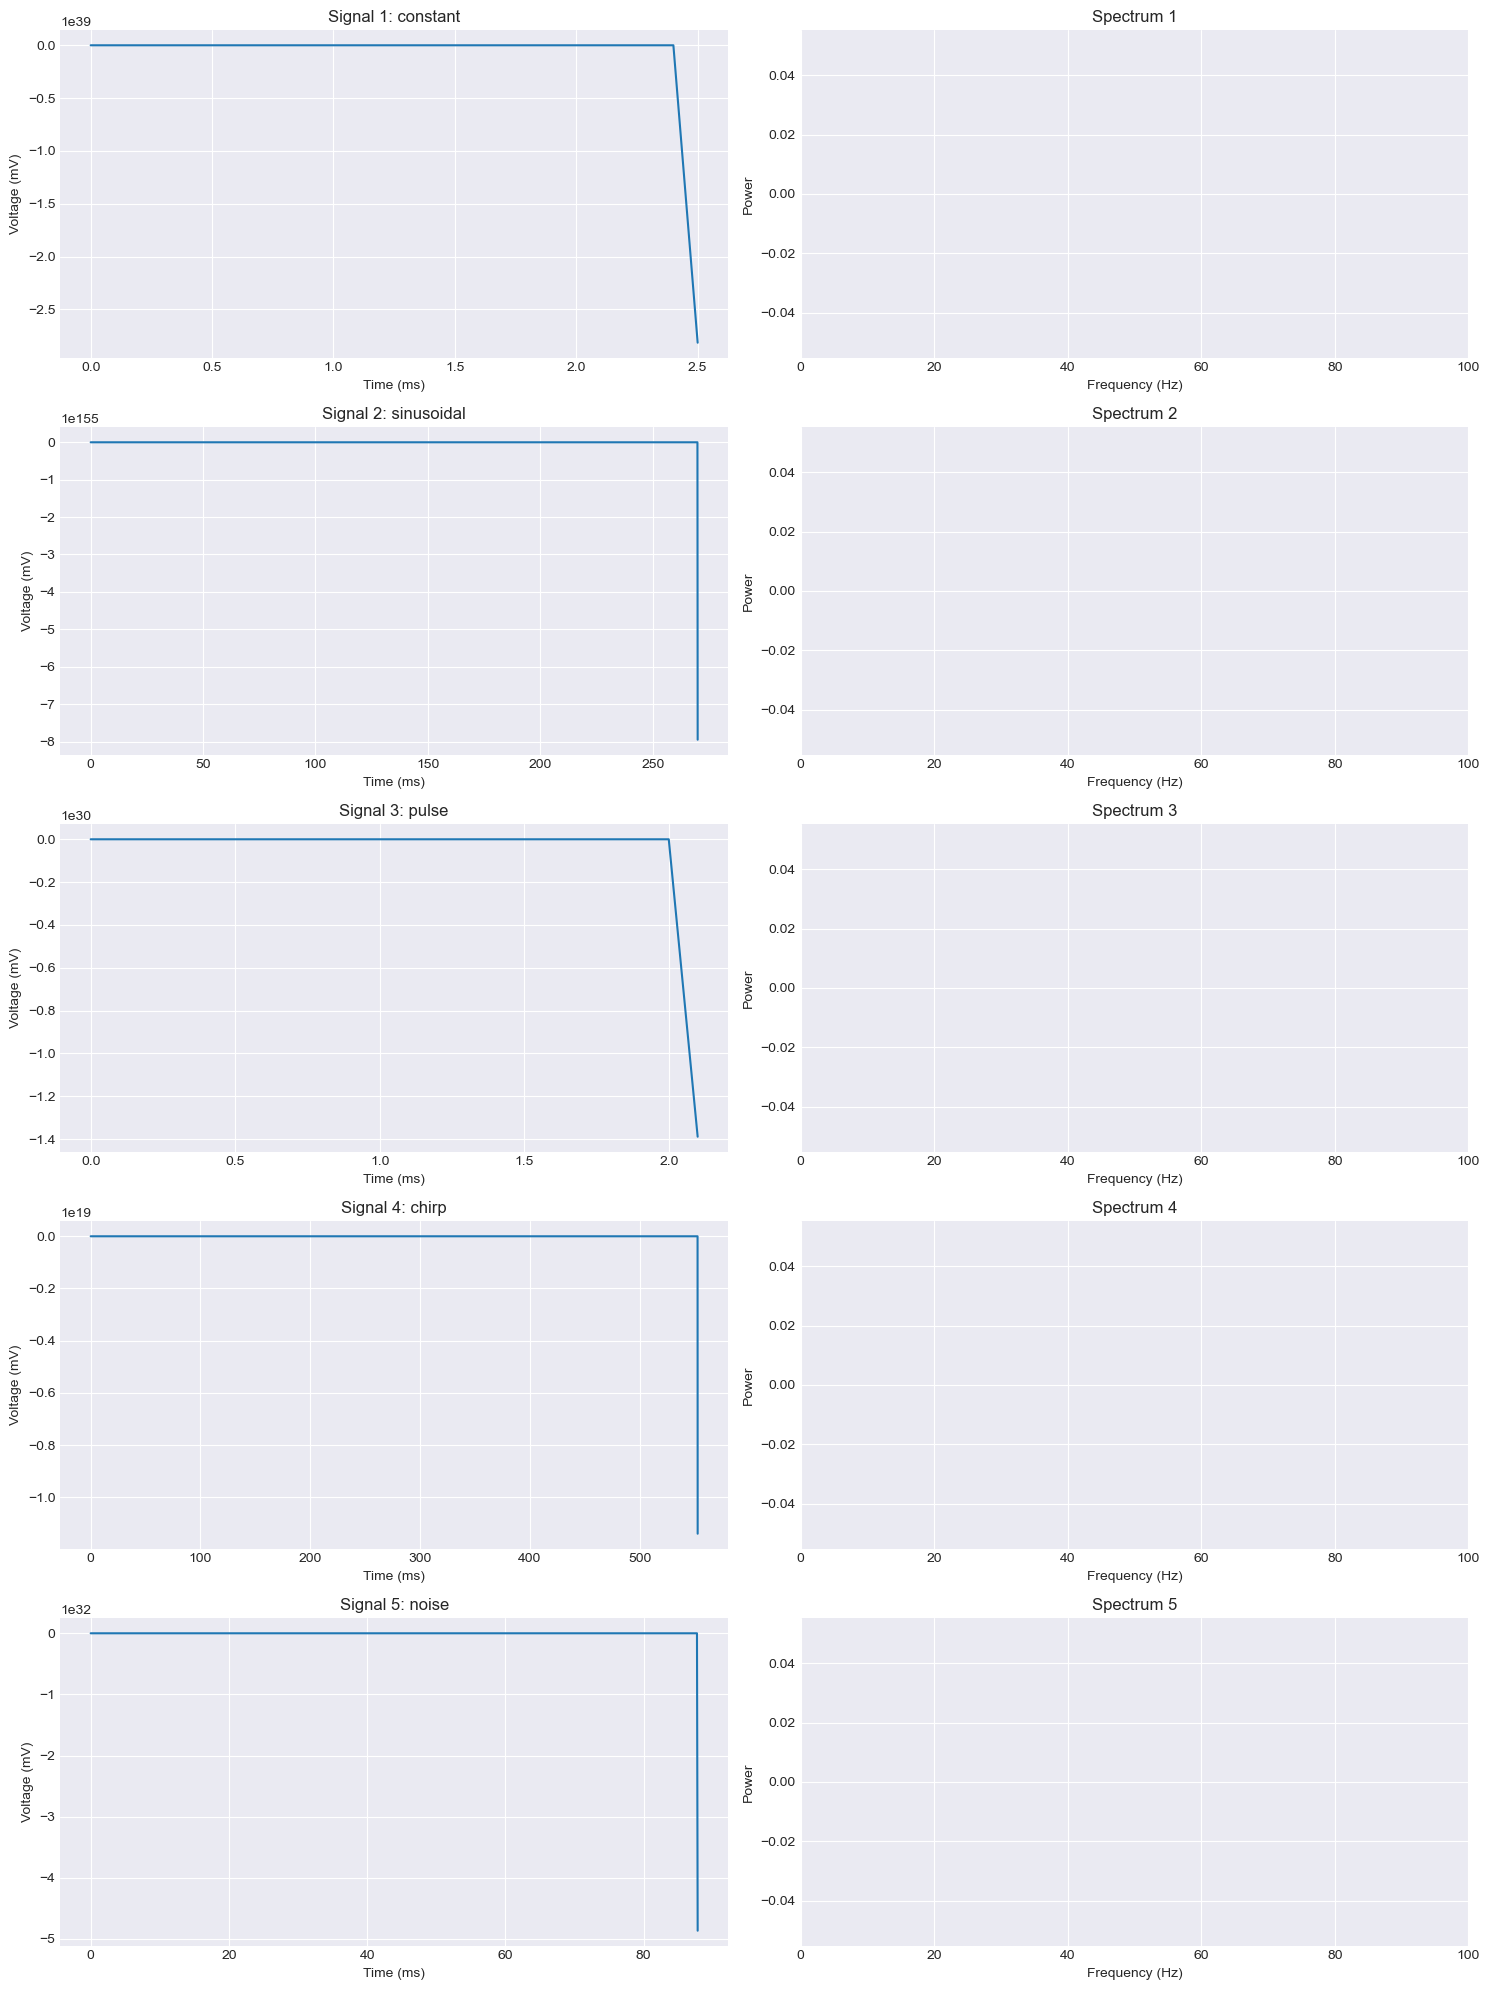

In [4]:
# Test different signal types
t_span = [0, 1000]  # Longer simulation time
dt = 0.1

signal_configs = [
    ('constant', {'amplitude': 15}),
    ('sinusoidal', {'amplitude': 20, 'frequency': 0.5}),
    ('pulse', {'amplitude': 25, 'period': 100}),
    ('chirp', {'amplitude': 15, 'f0': 0.1, 'f1': 1}),
    ('noise', {'amplitude': 10})
]

model = HodgkinHuxleyModel()
signals = []

for signal_type, params in signal_configs:
    model.reset_state()
    current_func = generate_test_signal(t_span, dt, signal_type, **params)
    t, V, _, _, _ = model.simulate(t_span, dt=dt, I_ext_func=current_func)
    signals.append((t, V))

# Plot results
fig, axes = plt.subplots(len(signals), 2, figsize=(15, 4*len(signals)))

for i, (t, V) in enumerate(signals):
    # Plot time domain
    axes[i,0].plot(t, V)
    axes[i,0].set_title(f'Signal {i+1}: {signal_configs[i][0]}')
    axes[i,0].set_xlabel('Time (ms)')
    axes[i,0].set_ylabel('Voltage (mV)')
    axes[i,0].grid(True)
    
    # Plot frequency domain
    freqs, power = analyze_spectrum(V, dt)
    axes[i,1].plot(freqs, power)
    axes[i,1].set_title(f'Spectrum {i+1}')
    axes[i,1].set_xlabel('Frequency (Hz)')
    axes[i,1].set_ylabel('Power')
    axes[i,1].set_xlim(0, 100)
    axes[i,1].grid(True)

plt.tight_layout()
plt.show()

Signal 1 (constant) matches: No criteria
Signal 2 (sinusoidal) matches: No criteria
Signal 3 (pulse) matches: No criteria
Signal 4 (chirp) matches: No criteria
Signal 5 (noise) matches: No criteria


ValueError: num must be an integer with 1 <= num <= 2, not 3

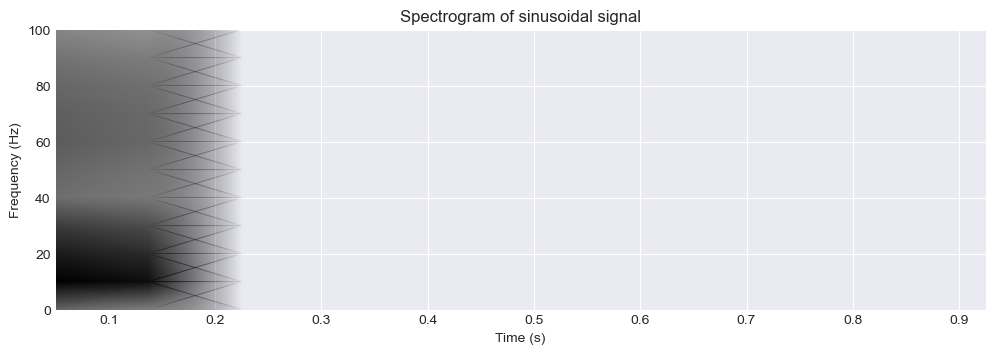

In [5]:
# Analyze spectral characteristics
criteria = [
    {'name': 'Low frequency', 'range': (0, 10), 'threshold': 0.1},
    {'name': 'Medium frequency', 'range': (10, 50), 'threshold': 0.1},
    {'name': 'High frequency', 'range': (50, 100), 'threshold': 0.05}
]

for i, (t, V) in enumerate(signals):
    freqs, power = analyze_spectrum(V, dt)
    matches = []
    
    for criterion in criteria:
        if has_desired_spectrum(freqs, power, criterion['range'], criterion['threshold']):
            matches.append(criterion['name'])
            
    print(f"Signal {i+1} ({signal_configs[i][0]}) matches: {', '.join(matches) if matches else 'No criteria'}")

# Generate spectrograms for time-varying signals
plt.figure(figsize=(12, 8))
for i in [1, 3]:  # sinusoidal and chirp signals
    plt.subplot(2, 1, i)
    t, V = signals[i]
    f, t_spec, Sxx = signal.spectrogram(V, fs=1000/dt, nperseg=1000)
    plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(f'Spectrogram of {signal_configs[i][0]} signal')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()